In [1]:
colab = False
if colab:
  import os
  if not os.path.isdir('../duckrace'):
    %pip install casadi
    !git clone https://github.com/giuliovv/duckrace.git
    %cd duckrace
    !apt-get install -y xvfb python-opengl
    %pip install pyvirtualdisplay
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    %pip install duckietown-gym-daffy

In [2]:
# Hyperparameters
test_results = True
N = 9
n_from_index = 0 # How far the first point is

In [3]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [4]:
plt.rcParams['figure.figsize'] = [7, 7]

In [5]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [6]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=15,
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [7]:
start_from_trajectory = True

# Trick to let the trajectory extractor see the whole line
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [8]:
dt = 1.0 / env.frame_rate

In [9]:
env.reset()
traj = utils.get_trajectory(env, samples=500, method="distance", last_value_distance=1.035)

/home/giulio/prog/duckrace/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [10]:
if start_from_trajectory:
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
    # Why double? Good question
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

In [11]:
pose = get_position(env)
pose

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

Text(1.9486294618007634, 1.9308421914242628, '|---------|')

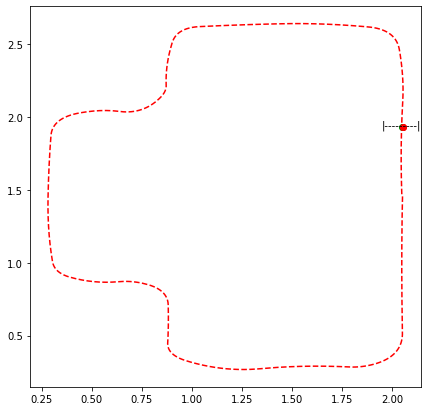

In [12]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
startpoint = (traj[index,0], traj[index,1])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")
plt.scatter(pose.x, pose.y, c="r")
plt.text(startpoint[0]-0.1, startpoint[1], '|'+'-'*9+'|')

In [13]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 188.0'

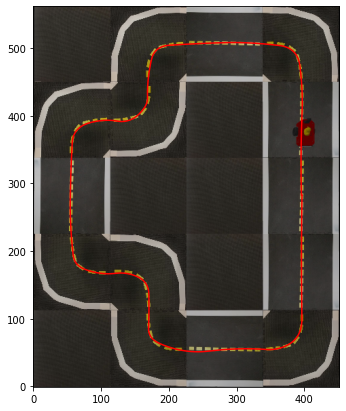

In [14]:
utils.show_on_map_array(env, traj[:,:2])

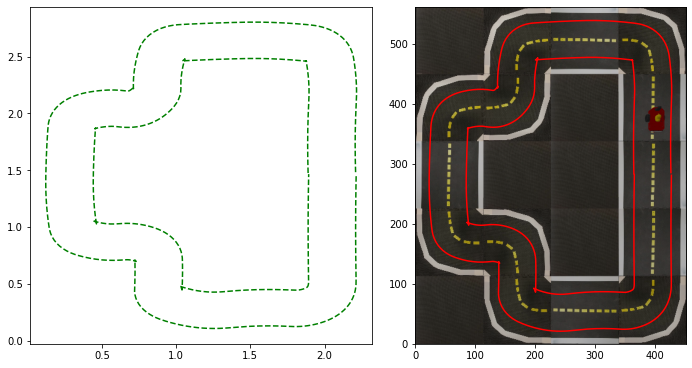

In [15]:
inside, outside = utils.get_border(traj, distance=0.16)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside, fig=ax_dict["B"])
utils.show_on_map_array(env, outside, fig=ax_dict["B"])

In [16]:
get_position(env)

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

In [17]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [18]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [19]:
traj[index]

array([2.04862946, 1.93084219, 1.54813545])

In [20]:
index = DM(index)
traj = DM(traj)
ins = DM(inside[::10].T)

Initialize states, inputs, and system dynamic equation

In [21]:
pose = get_position(env)

In [22]:
N_MPC = 10

delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N_MPC+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N_MPC+1)

# With preview
# Initial reference point
r0 = traj[index:index+N_MPC+1, :2].T
t0 = traj[index:index+N_MPC+1, 2].T

In [23]:
F = utils.model_F(dt=dt)

In [24]:
from collections import namedtuple
Line = namedtuple('Line', 't x y theta')
finish_line = Line(10*env.frame_rate, pose.x, pose.y, pose.theta) #2.2 same as start

In [25]:
# K nearest neighbors
K = 10

# N iterations to consider
i_j = 2
i_j_all = False

# Number of points to consider for convex margin constraints
CM = 4

In [26]:
sum1(DM([[1,2,3],[3,4,5]]))

DM([[4, 6, 8]])

In [27]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
l = opti.variable(K*i_j)      # Lambda of convex hull
l_margin = opti.variable(CM, N)      # Lambda for convex combination of margin
x0 = opti.parameter(5,1)    # Parameter to set the initial state conditions (x(0))
D = opti.parameter(5,K*i_j)     # Nearest neighbors
J = opti.parameter(1, K*i_j)    # A matrix time, iteration with the old states
t_to_N = opti.parameter(1, N-1)  # Next t time steps
margins = opti.parameter(2, CM)   # Margins for the track bound constraints

def h(x):
   # return 1 if it gets across the finish line
   # finish line is defined as the area where t is enough and y > y_finish
   return if_else(
       logic_and(
           t_to_N, 
           logic_and(x[1,:]>=finish_line.y, 
                     logic_and(mod(x[2,:], 2*pi)==finish_line.theta, x[0,:] == finish_line.x)
                    )
       ), 0, 1)

def boundary(l_margin):
    return if_else(vec(l_margin) >= 0, 0, 1e3)

obj = J@l + sum1(boundary(l_margin)) #+ sum1(h(x[:3,:N-1]))

opti.minimize(obj)

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k_ in range(0,N):
   opti.subject_to(x[:,k_+1] == F(x[:,k_],u[:,k_])) # No delay
   opti.subject_to(x[:2,k_+1] == margins@l_margin[:,k_]) # Convex combination of margins
opti.subject_to(sum1(l_margin) == 1) # Sum of convex coefficients of margins = 1
#opti.subject_to(vec(l_margin) >= 0) # Convex coefficients of margins >= 0
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == x0)
# 4) Set the convex hull constraints
opti.subject_to(l >= 0)
opti.subject_to(sum1(l) == 1)
opti.subject_to(D@l == x[:,N])

opti.set_value(x0,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0 # 8 to see constraint violations, see https://stackoverflow.com/questions/44558507/how-to-find-which-constraint-is-violated-from-pyomos-ipopt-interface
opts["ipopt.acceptable_constr_viol_tol"] = 1e-5
opts["print_time"] = False
opts["verbose"] = False
opti.solver('ipopt',opts)

## LMPC

In [28]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[x0, D, J, t_to_N, margins],[u[:,0], l],['x0', 'D', 'J', 't_to_N', 'central_line'],['u_opt', "lambda"])

### Loop 0

In [29]:
# First loop
Mpc = Function.load('M.casadi')


# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(traj[:, :2])

t = 0
while True:
    u = Mpc(x, r, tr, u_delay, 1000, 5e-4, 1, 1e-3)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N_MPC+1 < traj.shape[0]:
        r = traj[idx:idx+N_MPC+1, :2].T
        tr = traj[idx:idx+N_MPC+1, 2].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N_MPC+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N_MPC+1-traj.shape[0], 2]).T

    if traj[idx, 1] >= finish_line.y and t >= finish_line.t:
        break
    t += 1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



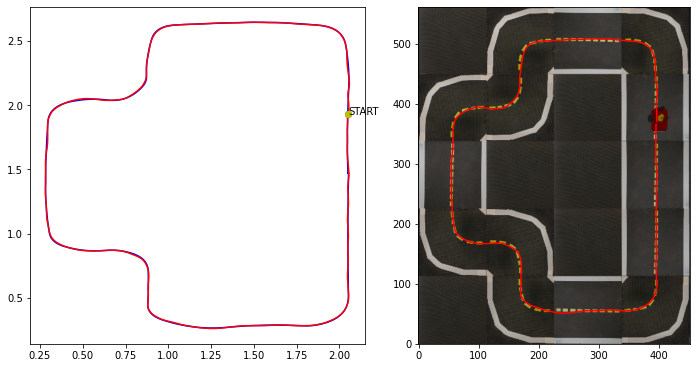

In [30]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [31]:
# all_points: [x, y, theta, v, w, steps to arrive]
all_points = X_log
X_log_orig = X_log
first_loop_len = all_points.shape[1]
all_points = np.vstack((all_points, np.arange(first_loop_len)[::-1]))
all_points_orig = all_points
x_orig = x

### Loop > 0

In [32]:
from sklearn.neighbors import NearestNeighbors

In [33]:
from IPython import display as ipythondisplay
from timeit import default_timer as timer

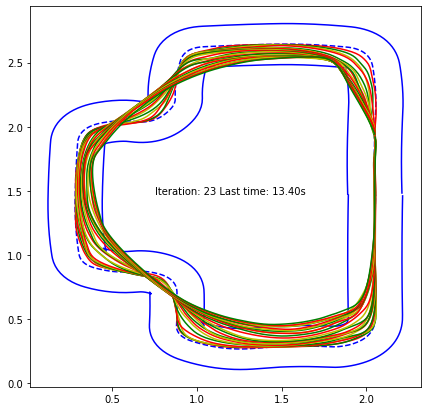

Iteration: 23, 
          avg time per step: 0.13369571267560823, 
          avg casadi time: 0.13177175797926924.
          avg iteration time: 28.69696965541713.
Last time:  [17.933333333333334, 16.6, 16.2, 17.733333333333334, 16.8, 16.466666666666665, 16.2, 16.066666666666666, 15.666666666666666, 15.066666666666666, 15.066666666666666, 14.6, 14.2, 13.733333333333333, 13.6, 13.666666666666666, 14.066666666666666, 14.4, 14.0, 13.6, 13.666666666666666, 13.799999999999999, 13.6, 13.4]


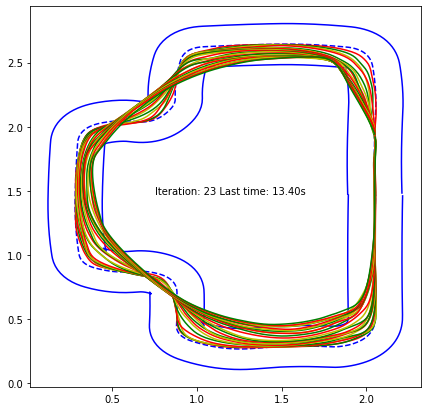

In [ ]:
n_iterations = 30

real_time_plot = True

# For debugging
X_log = X_log_orig
# X_log[2,:] = (X_log_orig[2,:]+np.pi) % (2*np.pi) - np.pi
all_points = all_points_orig
# all_points[2,:] = (all_points_orig[2,:]+np.pi) % (2*np.pi) - np.pi
last_iterations = np.hstack([all_points]*i_j)
x = x_orig

F = utils.model_F(dt=dt)

if idx+N > all_points.shape[1]:
    idx = all_points.shape[1] - idx

Js = []
idxs = []
plain_loops = []
loops_with_time = [all_points]

fig, ax = plt.subplots()

ax.plot(traj[:,0], traj[:,1], "b--")
ax.plot(*inside.T, "b")
ax.plot(*outside.T, "b")
t1 = ax.text(1.2, 1.5,"Iteration: 0, Last time: {:.2f}s".format(X_log.shape[1]*dt), ha='center', va='center')
plt.draw()

kdins = spatial.KDTree(inside)
ins_len = inside.shape[0]
# kdout = spatial.KDTree(outside)
# out_len = outside.shape[0]

step_times = [0]
casadi_times = [0]
iteration_times = [0]

for iteration in range(n_iterations):
    iteration_time_start = timer()
    last_loop = X_log
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    # Normalize the angles
    # Overfit the starting angle to avoid normalization problems ;)
    x[2] = mod(x[2]+pi, 2*pi)-pi

    # x = [pose.x, pose.y, pose.theta, 0, 0]
    # idx = int(index)

    kdtree = spatial.KDTree(last_loop[:2, :250].T)
    #nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations[:2, :100].T)
    last_iterations_filtered = last_iterations[np.vstack([last_iterations[-1] > K]*6)].reshape(6,-1)
    nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations_filtered[:2].T)
    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
    t = 0
    print(f"""Iteration: {iteration}, 
          avg time per step: {sum(step_times)/len(step_times)}, 
          avg casadi time: {sum(casadi_times)/len(casadi_times)}.
          avg iteration time: {sum(iteration_times)/len(iteration_times)}.""")
    print("Last time: ", [t.shape[1]*dt for t in loops_with_time])
    
    while True:
        start_step = timer()
        distances, indices = nbrs.kneighbors([last_loop[:2, (idx+N)%last_loop.shape[1]].T])
        indices = indices.reshape(-1)
        
        if t == 0:
            D = last_iterations_filtered[:-1, indices]
            J = last_iterations_filtered[-1, indices].reshape(-1)
        else:
            S = last_iterations_filtered[:, indices]@l
            distances, indices = nbrs.kneighbors(np.array(S[:2].T))
            indices = indices.reshape(-1)
            D = last_iterations_filtered[:-1, indices]
            J = last_iterations_filtered[-1, indices].reshape(-1)

        Js.append(J)
        idxs.append(idx)
        _, border_idx = kdins.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
        margins = np.array([
            inside[border_idx],
            inside[(border_idx+N+20)%ins_len],
            outside[border_idx],
            outside[(border_idx+N+30)%ins_len]]).T
        
        casadi_timer_start = timer()
        u, l = M(x, DM(D[:, :]), DM(J)/600, (np.arange(t, t+N-1)>=finish_line.t).T, margins)
        casadi_timer_end = timer()

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        # simulate
        x = F(x,u)

        #if real_time_plot and t%20 == 0:
        #    # plt.plot(*D[:2], 'go')
        #    plt.plot(*X_log[:2,:], c=['r', 'g', 'y'][iteration%3])
        #    # plt.plot(*margins, 'o')
        #    ipythondisplay.clear_output(wait=True)
        #    ipythondisplay.display(plt.gcf())

        _,idx_new = kdtree.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
        if idx_new >= idx:
            idx = idx_new
            if idx+N > traj.shape[0]:
                idx = traj.shape[0] - idx
        
        if x[1] >= finish_line.y and t >= finish_line.t and x[0] >= finish_line.x-0.1:
            break
        t += 1
        # if t == 100:
        #     break
        if t == K+N:
            # Now it can see all the points
            kdtree = spatial.KDTree(last_loop[:2, :].T)
            last_iterations_filtered = last_iterations
            nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations[:2, :].T)
            # The first points in the next iteration have distance 0 to the finish line
            last_iterations_filtered[:-1, :N] = X_log_orig[:, :N]
            #last_iterations_filtered[-1, :N] = 0
            # After one iteration the angle is +2*pi 
            last_iterations_filtered[2, :N] += 2*np.pi
        if t == loops_with_time[-1].shape[1]-K:
            last_iterations_filtered[-1, :N] = 0
        end_step = timer()
        step_times.append(end_step-start_step)
        casadi_times.append(casadi_timer_end-casadi_timer_start)
    if real_time_plot:
        ax.plot(*X_log[:2,:], c=['r', 'g', 'y'][iteration%3])
        t1.set_text("Iteration: {iteration} Last time: {time:.2f}s".format(iteration=iteration+1, time=X_log.shape[1]*dt))
        plt.draw()
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
    last_points = X_log
    last_points = np.vstack((last_points, np.arange(last_points.shape[1])[::-1]))

    plain_loops.append(X_log)
    loops_with_time.append(last_points)

    # I use the last i_j iterations
    if i_j_all:
        last_iterations = np.hstack(loops_with_time)
    else:
        last_iterations = np.hstack(loops_with_time[-i_j:])

    # all_points_len = all_points.shape[1]
    # if all_points_len > last_points.shape[1]:
    #     last_points = np.pad(last_points, ((0,0), (0, all_points_len-last_points.shape[1])), 'constant', constant_values=(0,0))
    # if all_points_len < last_points.shape[1]:
    #     all_points = np.pad(all_points, ((0,0), (0, last_points.shape[1]-all_points_len)), 'constant', constant_values=(0,0))
    # all_points = np.hstack((all_points, last_points))
    
    iteration_time_end = timer()
    iteration_times.append(iteration_time_end-iteration_time_start)

4.25 min /loop, 1 worker, N=10, K=50

3.10 min/loop, 1 worker, N=7, K=50

Con K troppo alto cerca di tagliare il circuito e si pianta per via del vincolo

In [34]:
[loop.shape[1]*dt for loop in plain_loops]

[16.6,
 16.2,
 17.733333333333334,
 16.8,
 16.466666666666665,
 16.2,
 16.066666666666666,
 15.666666666666666,
 15.066666666666666,
 15.066666666666666,
 14.6,
 14.2,
 13.733333333333333,
 13.6,
 13.666666666666666,
 14.066666666666666,
 14.4,
 14.0,
 13.6,
 13.666666666666666,
 13.799999999999999,
 13.6,
 13.4]

ERROR! Session/line number was not unique in database. History logging moved to new session 306


Best time: 12.33 N=10, K=30, i_j=5, i_j_all=True

12.133 N=15, K=30, i_j=5, i_j_all=True

12.8 N=10, K=80, i_j=1, i_j_all=True

12.76 N=10, K=100, i_j=1, i_j_all=True [17.03333333333333, 14.833333333333334, 13.366666666666667, 13.466666666666667, 13.166666666666666, 13.033333333333333, 12.966666666666667, 12.766666666666666, 13.1, 13.133333333333333, 12.933333333333334, 13.0]

12.63 with border not as constraint but as border and same params as before: [14.2,
 13.2,
 12.766666666666666,
 12.733333333333333,
 13.166666666666666,
 13.0,
 12.933333333333334,
 12.766666666666666,
 12.866666666666667,
 12.866666666666667,
 12.633333333333333,
 12.666666666666666]
 
 12.4 N=10, K=30, i_j=4, i_j_all=False, border, [15.633333333333333,
 13.933333333333334,
 13.533333333333333,
 12.966666666666667,
 13.233333333333333,
 13.033333333333333,
 12.766666666666666,
 12.766666666666666,
 12.4,
 12.566666666666666,
 12.533333333333333,
 12.533333333333333]
 
12.6 N=15, K=30, i_j=4, i_j_all=False, border, [16.733333333333334,
 15.333333333333334,
 14.066666666666666,
 13.466666666666667,
 13.333333333333334,
 13.1,
 13.299999999999999,
 13.466666666666667,
 13.433333333333334,
 13.2,
 13.133333333333333,
 12.6]
 
 11.7 N=10, K=30, i_j=4, i_j_all=False, border, [15.766666666666666,
 14.733333333333333,
 13.066666666666666,
 13.266666666666666,
 13.433333333333334,
 13.466666666666667,
 13.333333333333334,
 13.166666666666666,
 12.7,
 12.766666666666666,
 12.533333333333333,
 12.566666666666666,
 12.4,
 12.2,
 12.233333333333333,
 11.933333333333334,
 11.9,
 12.0,
 11.9,
 11.933333333333334,
 11.533333333333333,
 11.9,
 11.7,
 11.7,
 11.433333333333334,
 11.666666666666666,
 12.033333333333333,
 12.166666666666666,
 12.233333333333333,
 11.733333333333333] NB viola vincoli ma alla fine nella simulazione è ok
 
 Come prima ma i_j_all=True: [15.766666666666666,
 14.733333333333333,
 13.066666666666666,
 13.266666666666666,
 13.299999999999999,
 13.133333333333333,
 12.833333333333334,
 12.833333333333334,
 12.866666666666667,
 12.666666666666666,
 12.7,
 12.533333333333333,
 12.466666666666667,
 12.533333333333333,
 12.5,
 12.6,
 12.5,
 12.533333333333333,
 12.533333333333333,
 12.5,
 12.466666666666667,
 12.566666666666666,
 12.533333333333333,
 12.5,
 12.466666666666667,
 12.5,
 12.5,
 12.6,
 12.6,
 12.8], non viola vincoli
 
 N=10, K=40, i_j=4, i_j_all=True, [15.799999999999999,
 13.433333333333334,
 13.433333333333334,
 12.7,
 12.4,
 12.6,
 12.433333333333334,
 12.266666666666666,
 12.266666666666666,
 12.233333333333333,
 12.233333333333333,
 12.266666666666666,
 12.1,
 12.033333333333333,
 12.166666666666666,
 12.066666666666666,
 12.0,
 12.1,
 12.033333333333333,
 11.933333333333334,
 11.9,
 11.9,
 11.933333333333334,
 11.866666666666667,
 11.8,
 11.9,
 12.0,
 11.9,
 11.966666666666667,
 12.066666666666666]
 
 N=20 rompe ogni vincolo e finisce male

Text(0, 0.5, 'Time to finish [s]')

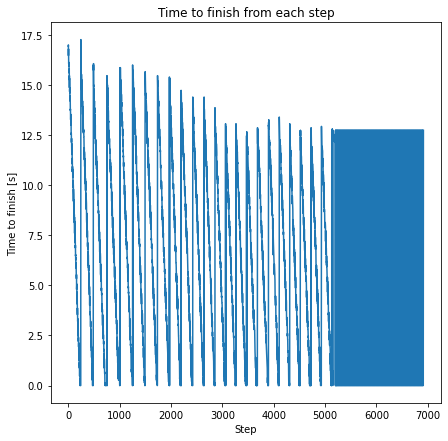

In [35]:
plt.plot(np.min(Js,axis=1)*dt, label="Time to finish")
plt.title("Time to finish from each step")
plt.xlabel("Step")
plt.ylabel("Time to finish [s]")

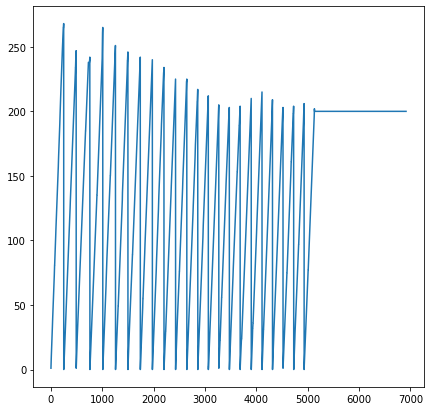

In [36]:
plt.plot(idxs)

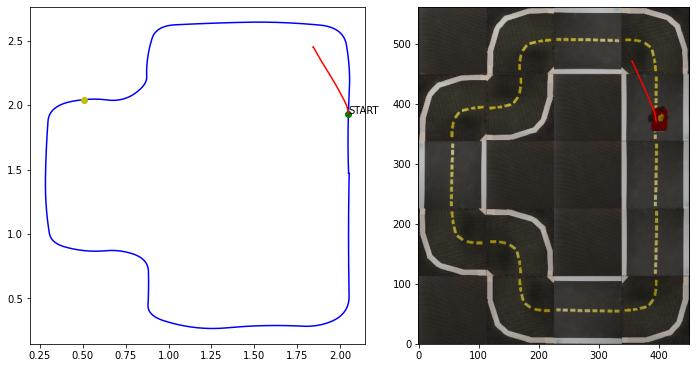

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC
        AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
# ax_dict["B"].plot(np.arange(len(errors))*dt, np.sqrt(errors))
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [38]:
xs = np.concatenate([loop[0,:] for loop in plain_loops])
ys = np.concatenate([loop[1,:] for loop in plain_loops])

In [39]:
save_video = False

if save_video:
    from matplotlib.animation import FuncAnimation

    ratio = 15
    fig,ax = plt.subplots()

    def init():
        ax.plot(traj[:,0], traj[:,1], "b--", zorder=0)
        ax.plot(*outside.T, "b", zorder=0)
        background = ax.plot(*inside.T, "b", zorder=0)
        return background

    def animate(i):
        line, = ax.plot(xs[:int(i*ratio)], ys[:int(i*ratio)], color='red', lw=1)
        return line

    ani = FuncAnimation(fig, animate, init_func=init, interval=(1/env.frame_rate)*ratio*1e3, blit=False, repeat=True, frames=int(xs.shape[0]/ratio))
    ani.save("assets/lmpc.mp4", writer='ffmpeg', dpi=300)

In [40]:
from IPython.display import Video

Video("assets/lmpc.mp4", width=600)

### Gym simulation

The MPC does not consider the delay yet!

In [41]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], X_log[2,0]%(2*np.pi)]
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], X_log[2,0]%(2*np.pi)]
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/lmpc_run.gif", images[::20], format='GIF', fps=env.frame_rate)

In [42]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [43]:
if record:
    utils.show_on_map(env, positions)

In [44]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/lmpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))